In [22]:
!pip install albumentations==1.4.3

In [23]:
from google.colab import drive
drive.mount('/content/drive')

## Libraries

In [24]:
from pathlib import Path
import os, math, random, zipfile
import cv2
import numpy as np
import pandas as pd
import albumentations as A

## Paths

In [25]:
ARCHIVE_PATH   = Path('/content/drive/MyDrive/A01_Dataset_DL_/DL_Assignment1_Dataset.zip')
ROOT_SPACE     = Path("/content/dataset_space")

DATA_NEST      = Path("Dataset/Dataset")
PHOTO_HOME     = "images"
TAG_HOME       = "annotations"
AUGMENT_ZONE   = "aug_photos"

## Data Extraction


In [26]:
if not ROOT_SPACE.exists():
    with zipfile.ZipFile(ARCHIVE_PATH, "r") as zf:
        zf.extractall(ROOT_SPACE)
else:
    print("Already extracted.")

CORE_PATH   = ROOT_SPACE / DATA_NEST
PHOTO_PATH  = CORE_PATH / PHOTO_HOME
LABEL_PATH  = CORE_PATH / TAG_HOME
AUG_PATH    = ROOT_SPACE / AUGMENT_ZONE
AUG_PATH.mkdir(exist_ok=True)


Already extracted.


In [27]:
records = []
missing_labels = 0

for pic in sorted(PHOTO_PATH.glob("*.jpg")):
    name = pic.stem
    exp_f, val_f, aro_f, lnd_f = [
        LABEL_PATH / f"{name}_{s}.npy" for s in ("exp","val","aro","lnd")
    ]
    if all(f.exists() for f in (exp_f, val_f, aro_f, lnd_f)):
        exp, val, aro, lnd = (np.atleast_1d(np.load(f, allow_pickle=True))
                              for f in (exp_f, val_f, aro_f, lnd_f))
        records.extend(
            (str(pic), int(e), float(v), float(a), float(g))
            for e, v, a, g in zip(exp, val, aro, lnd)
            if int(e) >= 0
        )
    else:
        missing_labels += 1
        print("Missing:", name)

print(f"Records: {len(records)} | Missing sets: {missing_labels}")
frame = pd.DataFrame(records,
                     columns=["path","expression","valence","arousal","landmark"])
frame.head()


Records: 3999 | Missing sets: 0


,path,expression,valence,arousal,landmark
0,/content/dataset_space/Dataset/Dataset/images/...,0,-0.176846,-0.077640,-0.006667
1,/content/dataset_space/Dataset/Dataset/images/...,0,-0.367789,0.183895,44.951579
2,/content/dataset_space/Dataset/Dataset/images/...,7,-0.648471,0.658149,7.733169
3,/content/dataset_space/Dataset/Dataset/images/...,3,0.150794,0.666667,29.836800
4,/content/dataset_space/Dataset/Dataset/images/...,0,-0.135501,0.004839,3.081315


## Augmentation

In [28]:
IMAGE_SIZE     = (224, 224)
AUG_TIMES      = 3

In [29]:
augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(0.3,0.3,p=0.5),
    A.HueSaturationValue(15,20,15,p=0.4),
    A.RandomGamma((80,120),p=0.3),
    A.CLAHE(clip_limit=3.0,tile_grid_size=(8,8),p=0.25),
    A.GaussNoise(var_limit=(10.0,50.0),p=0.3),
    A.RandomResizedCrop(IMAGE_SIZE, scale=(0.8,1.0), ratio=(0.9,1.1), p=0.5),
    A.ShiftScaleRotate(0.05,0.15,15,p=0.5)
])

def save_aug(src, dest):
    img = cv2.imread(str(src))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    aug = augmentor(image=img)["image"]
    cv2.imwrite(str(dest), cv2.cvtColor(aug, cv2.COLOR_RGB2BGR))

aug_data = []
for _, row in frame.iterrows():
    aug_data.append(tuple(row))
    stem = Path(row.path).stem
    for k in range(AUG_TIMES):
        out = AUG_PATH / f"{stem}_aug{k}.jpg"
        try:
            save_aug(row.path, out)
            aug_data.append((str(out), row.expression,
                             row.valence, row.arousal, row.landmark))
        except Exception as e:
            print("Aug error:", e)

aug_frame = pd.DataFrame(aug_data, columns=frame.columns)
print("Total with augments:", len(aug_frame))


Total with augments: 15996


/tmp/ipython-input-1808665637.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="expression", data=aug_frame, palette="viridis")


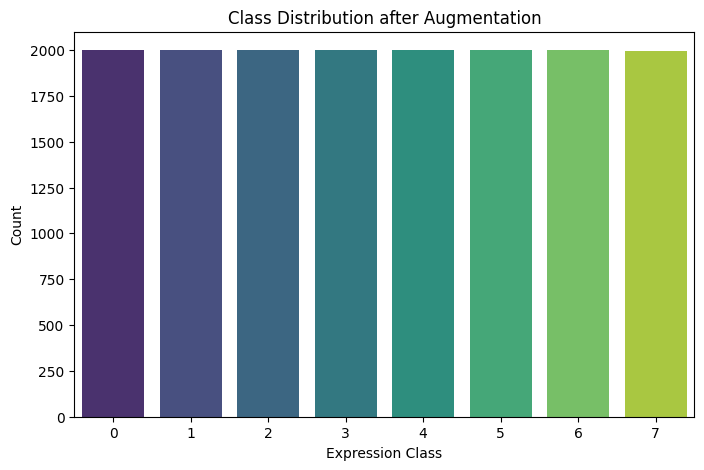

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x="expression", data=aug_frame, palette="viridis")
plt.title("Class Distribution after Augmentation")
plt.xlabel("Expression Class")
plt.ylabel("Count")
plt.show()


## Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [31]:
BATCH_SIZE = 16
SEED       = 42
NUM_CLASSES= 8
EPOCHS     = 20
np.random.seed(SEED)
random.seed(SEED)
RANDOM_SEED    = 42
CLASS_COUNT = 8
AUTOTUNE       = tf.data.AUTOTUNE

In [32]:
strat = aug_frame["expression"] if aug_frame["expression"].value_counts().min() > 1 else None
train_f, test_f = train_test_split(aug_frame, test_size=0.2,
                                   random_state=RANDOM_SEED,
                                   stratify=strat)
print("Train:", len(train_f), " Test:", len(test_f))

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

def make_ds(df, train=True):
    ds = tf.data.Dataset.from_tensor_slices((
        df.path.values, df.expression.values,
        df.valence.values, df.arousal.values, df.landmark.values
    ))
    if train: ds = ds.shuffle(len(df), seed=RANDOM_SEED)
    def prep(p,e,v,a,g):
        x = decode_img(p)
        return x, {"expr_out": tf.one_hot(e, CLASS_COUNT),
                   "cont_out": tf.stack([v,a,g])}
    return ds.map(prep, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = make_ds(train_f, True)
test_ds  = make_ds(test_f,  False)


Train: 12796  Test: 3200


## Model Building

In [33]:
from tensorflow.keras.applications import EfficientNetB0


In [35]:
def build_net():
    base = EfficientNetB0(include_top=False, input_shape=(*IMAGE_SIZE,3), weights="imagenet")
    for lyr in base.layers[:20]:
        lyr.trainable = False
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.4)(x)
    out_class = tf.keras.layers.Dense(CLASS_COUNT, activation="softmax", name="expr_out")(x)
    out_cont  = tf.keras.layers.Dense(3, activation="tanh", name="cont_out")(x)
    model = tf.keras.Model(base.input, [out_class, out_cont])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss={"expr_out":"categorical_crossentropy","cont_out":"mse"},
        loss_weights={"expr_out":1.0,"cont_out":0.2},
        metrics={"expr_out":"accuracy"}
    )
    return model

network = build_net()
history = network.fit(train_ds, epochs=EPOCHS, validation_data=test_ds, verbose=2)


Epoch 1/20
800/800 - 161s - 201ms/step - cont_out_loss: 197.8283 - expr_out_accuracy: 0.2742 - expr_out_loss: 1.8719 - loss: 41.4360 - val_cont_out_loss: 200.2234 - val_expr_out_accuracy: 0.2828 - val_expr_out_loss: 1.8899 - val_loss: 41.9346
Epoch 2/20
800/800 - 67s - 83ms/step - cont_out_loss: 197.2799 - expr_out_accuracy: 0.4626 - expr_out_loss: 1.4396 - loss: 40.9006 - val_cont_out_loss: 200.1267 - val_expr_out_accuracy: 0.3306 - val_expr_out_loss: 1.8182 - val_loss: 41.8436
Epoch 3/20
800/800 - 51s - 63ms/step - cont_out_loss: 197.2826 - expr_out_accuracy: 0.6053 - expr_out_loss: 1.0936 - loss: 40.5498 - val_cont_out_loss: 200.1723 - val_expr_out_accuracy: 0.3372 - val_expr_out_loss: 2.0117 - val_loss: 42.0462
Epoch 4/20
800/800 - 51s - 64ms/step - cont_out_loss: 197.2837 - expr_out_accuracy: 0.7259 - expr_out_loss: 0.7904 - loss: 40.2427 - val_cont_out_loss: 200.1434 - val_expr_out_accuracy: 0.3341 - val_expr_out_loss: 2.1976 - val_loss: 42.2263
Epoch 5/20
800/800 - 51s - 64ms/st

## Plots

In [36]:
import matplotlib.pyplot as plt

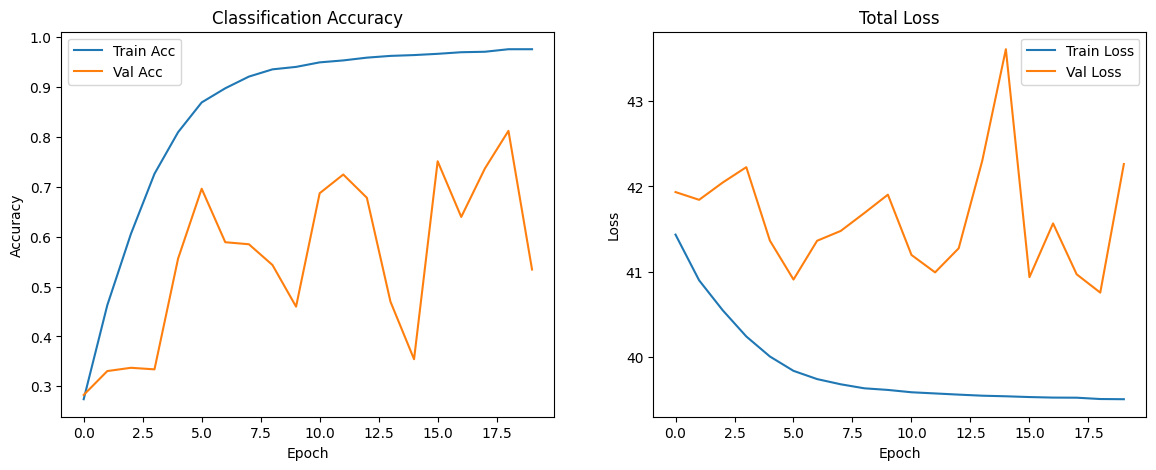

In [37]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["expr_out_accuracy"], label="Train Acc")
plt.plot(history.history["val_expr_out_accuracy"], label="Val Acc")
plt.title("Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [40]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, mean_squared_error
from scipy.stats import pearsonr


In [41]:
def ccc(a,b):
    a,b = np.array(a), np.array(b)
    ma, mb = a.mean(), b.mean()
    cov = np.mean((a-ma)*(b-mb))
    return (2*cov)/(a.var()+b.var()+(ma-mb)**2 + 1e-8)

def safe_corr(a,b):
    if np.allclose(a,a[0]) or np.allclose(b,b[0]): return np.nan
    return pearsonr(a,b)[0]

def evaluate(m, ds):
    yc, yp, yr, pr = [], [], [], []
    for x, y in ds:
        pc, cr = m.predict(x, verbose=0)
        yc.extend(tf.argmax(y["expr_out"],1).numpy())
        yp.extend(tf.argmax(pc,1).numpy())
        yr.extend(y["cont_out"].numpy())
        pr.extend(cr)
    yc, yp, yr, pr = map(np.array, (yc, yp, yr, pr))
    out = {
        "Accuracy": accuracy_score(yc, yp),
        "F1": f1_score(yc, yp, average="weighted"),
        "Kappa": cohen_kappa_score(yc, yp),
        "RMSE": math.sqrt(mean_squared_error(yr, pr))
    }
    for i, nm in enumerate(["Val","Aro","Lnd"]):
        out[f"{nm}CCC"]  = ccc(yr[:,i], pr[:,i])
        out[f"{nm}Corr"] = safe_corr(yr[:,i], pr[:,i])
    return out

results = evaluate(network, test_ds)
print("\nFinal metrics:")
for k,v in results.items():
    print(f"{k:10s}: {v:.4f}" if isinstance(v,float) else f"{k}: {v}")



Final metrics:
Accuracy  : 0.5341
F1        : 0.5102
Kappa     : 0.4675
RMSE      : 14.1450
ValCCC    : 0.5967
ValCorr   : 0.6399
AroCCC    : 0.4907
AroCorr   : 0.5255
LndCCC    : -0.0000
LndCorr   : -0.0012


In [44]:
import seaborn as sns

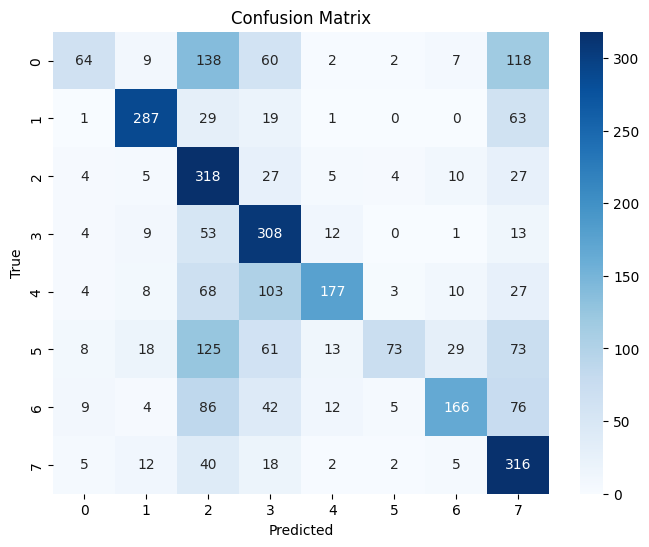

In [45]:
from sklearn.metrics import confusion_matrix
import numpy as np

# get true and predicted classes
y_true = []
y_pred = []
for x_batch, y_batch in test_ds:
    preds = network.predict(x_batch, verbose=0)
    y_true.extend(np.argmax(y_batch["expr_out"].numpy(), axis=1))
    y_pred.extend(np.argmax(preds[0], axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
